<h3> MLP: </h3>
Input -> Layer_0 -> Layer_1 -> Layer_2(Output) <br>
Input = Observation Space (Time, Joint Pos/Vel, ...) <br>
Output = Action Space (Muscle Actuator intensities for 63 muscles) <br>

<h3> Plan:  </h3> 
    - Define Directions in Radians <br> <br>
    - Compute Cosine Tuning for a neuron using the appropriate function: <br>  f(s) = r0 + (rmax - r0)* cos(s - smax) <br> <br>
    <b> rmax: </b> highest firing rate <br> <br>
    <b> r0: </b> firing rate when movement degree is null <br> <br>
    <b> smax: </b> direction angle at which firing rate is maximal  <br> <br>
    - store data of 100 episodes for each direction (baseline firing rate - max firing rate - preffered direction angle)


In [1]:
import myosuite
import gym
import skvideo.io
import numpy as np
import os
import imageio
import tqdm
import time

MyoSuite:> Registering Myo Envs


In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 400):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")


Get Policy

In [3]:
policy = "best_policy.pickle" #Change the folder to the policy location

import pickle
# load policy
pi = pickle.load(open(policy, 'rb'))

Get Object Coordinates

In [4]:

env = gym.make('CenterReachOut-v0')
coordinates_2d = []
for x in env.obj_xyz_range:
    coordinates_2d.append(x[:2])
    
print(coordinates_2d)


    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    
[[-0.05, -0.1], [0.1, -0.3], [0.15, -0.2], [0.1, -0.1], [-0.05, -0.4], [-0.15, -0.3], [-0.2, -0.2], [-0.15, -0.1]]


<h1> Turn into Polar Coordinates </h1>

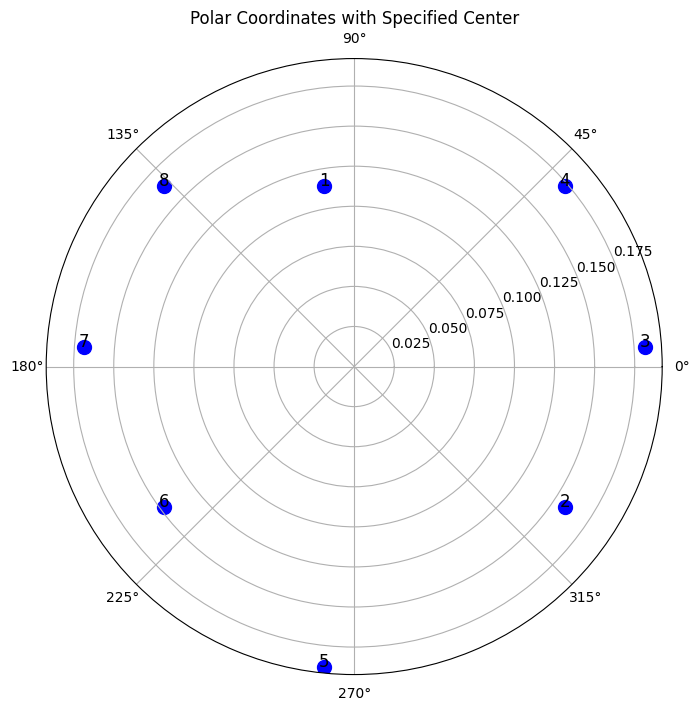

Point 1: r = 0.114, θ = 99.46°, xy: [-0.05, -0.1]
Point 2: r = 0.158, θ = -33.69°, xy: [0.1, -0.3]
Point 3: r = 0.182, θ = 3.95°, xy: [0.15, -0.2]
Point 4: r = 0.173, θ = 40.60°, xy: [0.1, -0.1]
Point 5: r = 0.188, θ = -95.71°, xy: [-0.05, -0.4]
Point 6: r = 0.148, θ = -143.62°, xy: [-0.15, -0.3]
Point 7: r = 0.169, θ = 175.76°, xy: [-0.2, -0.2]
Point 8: r = 0.164, θ = 136.55°, xy: [-0.15, -0.1]
{(-0.05, -0.1): 99.46232220802563, (0.1, -0.3): -33.690067525979785, (0.15, -0.2): 3.9451862290375583, (0.1, -0.1): 40.601294645004465, (-0.05, -0.4): -95.71059313749964, (-0.15, -0.3): -143.61564818416412, (-0.2, -0.2): 175.76360520094119, (-0.15, -0.1): 136.54815769897797}


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Given 2D Cartesian coordinates (x, y) and the center (xc, yc)
cartesian_coords_2d = coordinates_2d
center = (-0.03125, -0.21250)

# Conversion function for 2D Cartesian to Polar with a specified center
def cartesian_to_polar_center(coords, center):
    x, y = coords
    xc, yc = center
    x_prime = x - xc
    y_prime = y - yc
    r = np.sqrt(x_prime**2 + y_prime**2)
    theta = np.arctan2(y_prime, x_prime)
    return r, np.degrees(theta)

# Convert all 2D coordinates
polar_coords_2d_centered = [cartesian_to_polar_center(coord, center) for coord in cartesian_coords_2d]

# Extract r and theta values
r_values = [coord[0] for coord in polar_coords_2d_centered]
theta_values = [np.radians(coord[1]) for coord in polar_coords_2d_centered]  # Convert degrees to radians for plotting

# Create polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.scatter(theta_values, r_values, c='blue', s=100)  # Plot the points

# Add labels for clarity
for i, (r, theta) in enumerate(zip(r_values, theta_values)):
    ax.text(theta, r, f'{i+1}', fontsize=12, ha='center')

ax.set_title("Polar Coordinates with Specified Center")
plt.show()

coords_to_angles = {}

# Print the results
for i, (r, theta) in enumerate(polar_coords_2d_centered):
    coords_to_angles[tuple(cartesian_coords_2d[i])] = theta
    print(f"Point {i+1}: r = {r:.3f}, θ = {theta:.2f}°, xy: {cartesian_coords_2d[i]}")

print(coords_to_angles)



coords_to_angles dictionary now contains the coordinates with their assigned angle

<h1> Setting up the data collection </h1>
<p> We will create a dictionary that contains: <br>
    - Keys = Action Number (int) <br>
    - Values = Angle (float) - Neuron Activations (list) <br>
    </p>

In [6]:
# Use sleep if you want to examine certain steps during the episodes
from time import sleep

Cosine_Tuning_Data = {} 

frames = []
for ep_num in range(100): 
  env.reset()
  ep_rewards = []
  done = False
  obs = env.reset()
  for ac_num in range(10):
      frame = env.sim.renderer.render_offscreen(
                        width=400,
                        height=400,
                        camera_id=1)
      frames.append(frame)
      o = env.get_obs()
      action, _ = pi.get_action(o)
      obs, reward, done, info = env.step(action)
      
      #Register the data for every action in each episode
      Cosine_Tuning_Data[ep_num*10 + ac_num] = [coords_to_angles[tuple(env.current_object_pos[:2])], pi.show_activations()['layer_0'][0][7] ]
      

print(Cosine_Tuning_Data)

env.close()

os.makedirs('videos', exist_ok=True)
video_path = 'videos/test_policy.mp4'
# make a local copy
imageio.mimsave(video_path, frames, fps=30)
show_video('videos/test_policy.mp4')

{0: [3.9451862290375583, 0.42119443], 1: [3.9451862290375583, 0.47203344], 2: [3.9451862290375583, 0.49054465], 3: [3.9451862290375583, 0.5605617], 4: [3.9451862290375583, 0.5753748], 5: [3.9451862290375583, 0.6556269], 6: [3.9451862290375583, 0.65591455], 7: [3.9451862290375583, 0.6540611], 8: [3.9451862290375583, 0.63990766], 9: [3.9451862290375583, 0.7117334], 10: [3.9451862290375583, 0.42119443], 11: [3.9451862290375583, 0.5044001], 12: [3.9451862290375583, 0.52231055], 13: [3.9451862290375583, 0.57512605], 14: [3.9451862290375583, 0.62723786], 15: [3.9451862290375583, 0.6008543], 16: [3.9451862290375583, 0.61506224], 17: [3.9451862290375583, 0.6398459], 18: [3.9451862290375583, 0.65815234], 19: [3.9451862290375583, 0.65185], 20: [-95.71059313749964, 0.4106755], 21: [-95.71059313749964, 0.5048588], 22: [-95.71059313749964, 0.5308982], 23: [-95.71059313749964, 0.5016092], 24: [-95.71059313749964, 0.5515283], 25: [-95.71059313749964, 0.53616315], 26: [-95.71059313749964, 0.5558671], 

<h1> Create a Table with Data </h1>

In [ ]:
import pandas as pd

data = Cosine_Tuning_Data

# Create a DataFrame
df = pd.DataFrame.from_dict(data, orient='index', columns=['Angle', 'Neuron Activation'])

# Display the DataFrame
print(df)

# Create a DataFrame
df = pd.DataFrame.from_dict(data, orient='index', columns=['Angle', 'Neuron Activation'])

# Convert DataFrame to HTML table
html_table = df.to_html()


# Write HTML table to a file
with open('table.html', 'w') as f:
    f.write(html_table)

In [8]:
import pandas as pd

# Assuming your data is loaded into a DataFrame called df with columns "Angle" and "Neuron activation"

# Group by 'Angle' and calculate mean and standard deviation
mean_std_by_angle = df.groupby('Angle')['Neuron Activation'].agg(['mean', 'std'])

# Print the result
print(mean_std_by_angle)

                 mean       std
Angle                          
-143.615648  0.508465  0.066961
-95.710593   0.532517  0.070579
-33.690068   0.553230  0.077855
 3.945186    0.564097  0.084289
 40.601295   0.549335  0.089152
 99.462322   0.517081  0.077147
 136.548158  0.498551  0.066229
 175.763605  0.499547  0.067403
